# DP4: Control of a drone
### Authors: Krishna Modi and Patrick Thornton

### Import necessary libraries and configure the notebook:

In [1]:
# all necessary imports
import os
import sympy as sym
import time
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import secrets
import importlib
import ae353_drone
importlib.reload(ae353_drone)

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Jan 28 2022 20:18:15


Create an instance of the Simulator using the `Simulator` class:\
NOTE: RUN THIS CELL ONLY ONCE - Restart the kernel to create a new simulator

## Set a desired seed for the simulator to that results may be reproduced

*optional: use the random number generator to define a randomized seed*

In [2]:
seed = 992752186

# seed = secrets.randbits(32)
# print(seed)

Create simulator with seed.

In [3]:
simulator = ae353_drone.Simulator(
    display=True,
    seed=seed,
)

## Define equations of motion for the dynamic model and construct $f$

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

Define physical parameters.

In [4]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive the equations of motion:

In [5]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world * v_in_body,
    M * w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() * (tau_in_body - w_in_body.cross(J * w_in_body)),
)

f = sym.simplify(f, full=True)

Here is the function $f$:

In [6]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

Since there are no second order ODEs, we can proceed with linearization.

## Define equilibrium point and verify that $f = 0$

Define equilbrium points and set up the function to linearize the system:

In [7]:
p_x_eq = 0. # m
p_y_eq = 0. # m
p_z_eq = 0. # m
psi_eq = 0. # rad
theta_eq = 0. # rad
phi_eq = 0. # rad
v_x_eq = 0. # rad
v_y_eq = 0. # rad
v_z_eq = 0. # rad
w_x_eq = 0. # rad
w_y_eq = 0. # rad
w_z_eq = 0. # rad
tau_x_eq = 0. # rad
tau_y_eq = 0. # rad
tau_z_eq = 0. # rad
f_z_eq = 4.905 # rad

f_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f)
f_eq = f_num(p_x_eq, p_y_eq, p_z_eq, psi_eq, theta_eq, phi_eq, v_x_eq, v_y_eq, v_z_eq, w_x_eq, w_y_eq, w_z_eq, tau_x_eq, tau_y_eq, tau_z_eq, f_z_eq)
print(f_eq)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


## Linearize the system and compute A and B matrices to place the system in state-space form:

In [8]:
f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
# Create lambda function
A_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

# Evaluate lambda function at equilibrium point
A = A_num(p_x_eq, p_y_eq, p_z_eq, psi_eq, theta_eq, phi_eq, v_x_eq, v_y_eq, v_z_eq, w_x_eq, w_y_eq, w_z_eq, tau_x_eq, tau_y_eq, tau_z_eq, f_z_eq)

# Create lambda functions
B_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f.jacobian([tau_x, tau_y, tau_z, f_z]), 'numpy')

# Evaluate lambda function at equilibrium point
B = B_num(p_x_eq, p_y_eq, p_z_eq, psi_eq, theta_eq, phi_eq, v_x_eq, v_y_eq, v_z_eq, w_x_eq, w_y_eq, w_z_eq, tau_x_eq, tau_y_eq, tau_z_eq, f_z_eq)

# Display the result
print(f'A =\n{A}\n')
print(f'B =\n{B}\n')

A =
[[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.    0.   -0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.   -0.    0.    0.    0.    0.    1.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.   -0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81 -0.    0.    0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.    0.   -0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

B =
[[  0.          0.          0.          0.       ]
 [  0.          0.          0.         

## Determine if the system is controllable

Compute the controllability matrix $\boldsymbol{W}_c$ and confirm that it is full rank (since we have 12 states we need to check the rank(W) and ensure it equals 12):

In [9]:
n = A.shape[0]

# Initialize W with its first column
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
    
# print(W)
r = np.linalg.matrix_rank(W)
print(f'Largest possible rank = {A.shape[0]}\n')
print(f'Rank of controllability matrix = {r}\n')

Largest possible rank = 12

Rank of controllability matrix = 12



Since the rank(W) = 12, this system is controllable. Now, we can go ahead and linearlize the sensor model and ensure that the system is observable.

## Get the symbolic form of $g$

Define the sensor model.

In [10]:
g = sym.Matrix([p_x, p_y, p_z, psi])

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi)$$

Here is the function $g$:

In [11]:
g

Matrix([
[p_x],
[p_y],
[p_z],
[psi]])

Since there are no second order ODEs, we can proceed with linearization.

## Linearize the Sensor Model

Linearize the sensor and compute C and D.

In [12]:
g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
# Create lambda function
C_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

# Evaluate lambda function at equilibrium point
C = C_num(p_x_eq, p_y_eq, p_z_eq, psi_eq, theta_eq, phi_eq, v_x_eq, v_y_eq, v_z_eq, w_x_eq, w_y_eq, w_z_eq, tau_x_eq, tau_y_eq, tau_z_eq, f_z_eq)

# Create lambda functions
D_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], g.jacobian([tau_x, tau_y, tau_z, f_z]), 'numpy')

# Evaluate lambda function at equilibrium point
D = D_num(p_x_eq, p_y_eq, p_z_eq, psi_eq, theta_eq, phi_eq, v_x_eq, v_y_eq, v_z_eq, w_x_eq, w_y_eq, w_z_eq, tau_x_eq, tau_y_eq, tau_z_eq, f_z_eq)

# Display the result
print(f'C =\n{C}\n')
print(f'D =\n{D}\n')

C =
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]]

D =
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]



In [13]:
g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

## Determine if the system is observable

Compute the observability matrix $\boldsymbol{W}_o$ and confirm that it is full rank (since we have 12 states we need to check the rank(W_obs) and ensure it equals 12):

In [14]:
n = A.shape[0]

# Initialize W with its first column
W_obs = C.T

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A.T, i) @ C.T
    W_obs = np.block([W_obs, col])
    
# print(W_obs)
r = np.linalg.matrix_rank(W_obs)
print(f'Largest possible rank = {A.shape[0]}\n')
print(f'Rank of obervability matrix = {r}\n')

Largest possible rank = 12

Rank of obervability matrix = 12



Since the rank(W_obs) = 12, this system is observable. Now, we can go ahead and find the gain matrix K for the controller, the gain matrix L for the observer, and ensure asymptotic stability for both the controller and observer.

## Compute a controller gains matrix $K$ using LQR
Then verify that the controller is asymptotically stable in theory by verifying all eigenvalues have negative real part.

In [15]:
Q_cont = np.diag([1.2, 1.5, 2.0, 1.7, 1.5, 1.5, 1.2, 1.0, 1.0, 1.2, 1.0, 1.0])
R_cont = np.diag([30., 40., 30., 30.])

P_cont = linalg.solve_continuous_are(A, B, Q_cont, R_cont)
K = linalg.inv(R_cont) @ B.T @ P_cont
print(f'K =\n{K}\n')

K =
[[ 0.         -0.2236068  -0.          0.          0.          1.1181764
  -0.         -0.29035879 -0.          0.21247026  0.         -0.        ]
 [ 0.17320508  0.          0.          0.          0.93406636  0.
   0.25096553  0.          0.          0.          0.1711628  -0.        ]
 [ 0.         -0.          0.          0.23804761 -0.          0.
  -0.         -0.          0.         -0.         -0.          0.18771711]
 [-0.         -0.          0.25819889  0.         -0.          0.
  -0.         -0.          0.53993724 -0.          0.          0.        ]]



Now that we have found the K matrix, we can check that this controller is asymptotically stable by checking that the real components of the eigenvalues of the (A-BK) matrix are negative.

In [16]:
F = A - (B@K)
s = np.linalg.eigvals(F)
print(s)

[-68.73443022+0.j          -2.34100832+2.29008175j
  -2.34100832-2.29008175j  -1.00216328+0.j
 -86.94939376+0.j         -45.62490486+0.j
  -2.10349808+2.13343102j  -2.10349808-2.13343102j
  -1.22198406+0.j          -1.30437321+0.j
  -0.53993724+0.47419991j  -0.53993724-0.47419991j]


Since all the real components of the eigenvalues of the (A-BK) matrix are negative, the controller is deemed to be asymptotically stable. Now, we can go ahead and find the gain matrix for the observer L, and check that the observer is asymptotically stable.

## Compute an observer gains matrix $L$ using LQR
Then verify that the observer is asymptotically stable in theory by verifying all eigenvalues have negative real part.

In [17]:
Q_obs = np.diag([30., 40., 30., 30.])
R_obs = np.diag([1.2, 1.5, 2.0, 1.7, 1.5, 1.5, 1.2, 1.0, 1.0, 1.2, 1.0, 1.0])

P_obs = linalg.solve_continuous_are(A.T, C.T, linalg.inv(R_obs), linalg.inv(Q_obs))
L = P_obs @ C.T @ Q_obs
print(f'L =\n{L}\n')

L =
[[10.11598839  0.          0.          0.        ]
 [ 0.         10.45391741  0.          0.        ]
 [ 0.          0.          5.09455112  0.        ]
 [ 0.          0.          0.          5.34803796]
 [ 7.94842893  0.          0.          0.        ]
 [ 0.         -8.67697366  0.          0.        ]
 [38.66661051  0.          0.          0.        ]
 [ 0.         41.30886125  0.          0.        ]
 [ 0.          0.          5.47722558  0.        ]
 [ 0.         -5.77350269  0.          0.        ]
 [ 5.47722558  0.          0.          0.        ]
 [ 0.          0.          0.          5.47722558]]



Now that we have found the L matrix, we can check that this observer is asymptotically stable by checking that the real components of the eigenvalues of the (A-LC) matrix are negative.

In [18]:
F = A - (L@C)
s = np.linalg.eigvals(F)
print(s)

[-5.15978928+0.j         -1.86808061+2.24626002j -1.86808061-2.24626002j
 -5.32107006+0.j         -1.2200379 +0.j         -2.006295  +2.34014269j
 -2.006295  -2.34014269j -3.96752272+0.j         -3.55295305+0.j
 -1.12025736+0.j         -1.54159807+0.j         -1.38051524+0.j        ]


Since all the real components of the eigenvalues of the (A-LC) matrix are negative, the observer is deemed to be asymptotically stable. Now, we can go ahead and implement the controller and observer for simulations.

## Define a controller that maps sensor measurements to actuator commands

Define a controller for the drone with observer implementation.

In [19]:
class Controller:
    def __init__(self):
        self.dt = 0.01 # s
        self.p_x_eq = 0. # m
        self.p_y_eq = 0. # m
        self.p_z_eq = 0. # m
        self.psi_eq = 0. # rad
        self.theta_eq = 0. # rad
        self.phi_eq = 0. # rad
        self.v_x_eq = 0. # rad
        self.v_y_eq = 0. # rad
        self.v_z_eq = 0. # rad
        self.w_x_eq = 0. # rad
        self.w_y_eq = 0. # rad
        self.w_z_eq = 0. # rad
        self.tau_x_eq = 0. # rad
        self.tau_y_eq = 0. # rad
        self.tau_z_eq = 0. # rad
        self.f_z_eq = 4.905 # rad
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.reset(0., 0., 0., 0.)
        self.variables_to_log = ['x_des', 'xhat']
        self.r = 2.45
        self.u_des = np.array([0., 0., 0., 0.])
        self.x_des = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 

    def get_color(self):
        return [0., 0., 0.]

    def reset(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
        ):
        self.xhat = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas, 0., 0., 0., 0., 0., 0., 0., 0.]) # Define initial state estimate

    def run(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
            p_x_ring, p_y_ring, p_z_ring, # <-- center position of next ring (meters)
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        
        # Initialize and update the desired state
        if p_z_meas < 0.5: # We want the vertical height of the drone to clear the initial ring, so we make the drone achieve a height of 0.8 m before it moves to the next ring
            self.x_des[0:3] = np.array([p_x_meas, p_y_meas, 0.6])
            
        else: # Once the desired vertical height is reached, the drone will start moving through the rings
            self.phat = np.array([p_x_meas, p_y_meas,  p_z_meas])
            self.p_ring = np.array([p_x_ring, p_y_ring, p_z_ring])
            
            # compute vector between ring and estimated position
            d = self.p_ring - self.phat
            
            # implement tracking as defined in equation (14)
            self.p_des = self.phat + self.r*d / np.linalg.norm(d)
            self.x_des[0:3] = self.p_des
        
        # find input
        u = self.u_des - self.K @ (self.xhat - self.x_des)
        
        # implement system output
        y = np.array([p_x_meas - self.p_x_eq, p_y_meas - self.p_y_eq, p_z_meas - self.p_z_eq, yaw_meas - self.psi_eq])
        
        # find state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L@(self.C@self.xhat - y))
        
        # relay actuator commands and f_z
        tau_x = u[0] + self.tau_x_eq
        tau_y = u[1] + self.tau_y_eq
        tau_z = u[2] + self.tau_z_eq
        f_z = u[3] + self.f_z_eq

        return tau_x, tau_y, tau_z, f_z

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'my_netid'` is the name of the drone
* `'my_image.png'` is the name of an image to use as a label (can be `None`, can be a file path)

In [20]:
simulator.add_drone(Controller, 'pdt4', 'pdt4.png')

In [23]:
simulator.camera_droneview('pdt4')

Optional: run the simulator for 1 instance for visual observation purposes

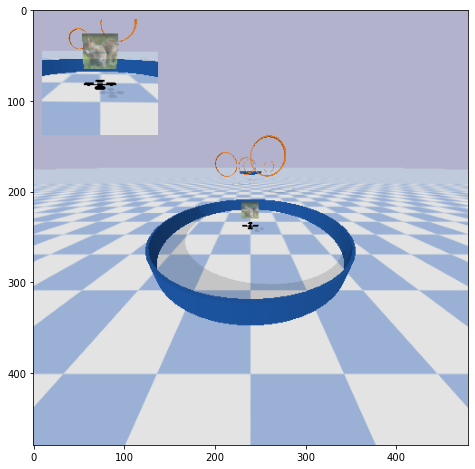

In [27]:
# simulator.reset()

# # Get snapshot as height x width x 4 numpy array of RGBA values
# rgba = simulator.snapshot()

# # Display snapshot
# plt.figure(figsize=(8, 8))
# plt.imshow(rgba)

# # Save snapshot
# plt.imsave('drone_start.png', rgba)

# simulator.run(max_time=30.0, video_filename='drone_vid.mov')
# data = simulator.get_data('pdt4')
# completion_time = data['t'][-1]
# print(f'\nCompletion Time: \n{completion_time}')

The function below will be used to calculate the Root-Mean-Square Error in yaw, pitch, and roll angles across all simulations.

In [21]:
def rmse(actual, equilibrium):
    return np.sqrt(((actual - equilibrium) ** 2).mean())

## Run the simulator and collect data for 100 simulations

In [22]:
# initialize lists to store data for plotting
actual_position_error = []
estimated_position_error = []
completion_times = []
run_times = []
count = 0

# run the simulator until data is collected for 100 simulations
for i in range(100):
    simulator.reset()
    simulator.run(max_time=45.0)
    data = simulator.get_data('my_netid')
    
    # initialize lists to store position errors used for calculations
    actual_position_error_x = []
    actual_position_error_y = []
    actual_position_error_z = []
    estimated_position_error_x = []
    estimated_position_error_y = []
    estimated_position_error_z = []
    
    # compute RMSE between actual position and desired position by coordinate
    actual_position_error_x.append(rmse(data['p_x'], data['x_des'][:,0]))
    actual_position_error_y.append(rmse(data['p_y'], data['x_des'][:,1]))
    actual_position_error_z.append(rmse(data['p_z'], data['x_des'][:,2]))
    
    # compute norm of RMSE in x, y, and z and append to list for plotting
    actual_position_error.append(np.linalg.norm(np.array([actual_position_error_x, actual_position_error_y, actual_position_error_z])))
    
    # compute RMSE between estimated position and actual position by coordinate
    estimated_position_error_x.append(rmse(data['p_x_meas'], data['p_x']))
    estimated_position_error_y.append(rmse(data['p_y_meas'], data['p_y']))
    estimated_position_error_z.append(rmse(data['p_z_meas'], data['p_z']))
    
    # compute norm of RMSE in x, y, and z and append to list for plotting
    estimated_position_error.append(np.linalg.norm(np.array([estimated_position_error_x, estimated_position_error_y, estimated_position_error_z])))
    
    # store each race completion time in a list
    completion_times.append(data['t'][-1])
    
    # each simulation calls the controller class every time step and stores the computation time in an array
    # > iterate through each computation time and store it in a list containing times for all simulations
    for j in data['run_time']:
        run_times.append(j)
    
    # variable 'count' tracks the number of races that finish in under 30 seconds
    if data['t'][-1] <= 30:
        count += 1

## Plot histograms and compute relevant statistics

For 100 simulations run in aggregate, histograms were plotted to show:

* error between actual position and desired position

* error between estimated position and actual position

* completion times

* computation times


The number of simulations that have a run time less than or equal to 30 seconds: 
100

70th %ile RMSE in regards to calculated vs actual position: 
0.01742152031343303

Maximum RMSE in regards to calculated vs actual position: 
0.01769798975124507

Minimum completion time: 
23.0

Maximum completion time: 
24.84

Mean completion time: 
24.002700000000004

Median completion time: 
24.025

Standard deviation of completion times: 
0.41795180344149735

Minimum computation time: 
3.7670135498046875e-05

Maximum computation time: 
0.05768895149230957

Mean computation time: 
6.203467704718524e-05

Median computation time: 
5.698204040527344e-05


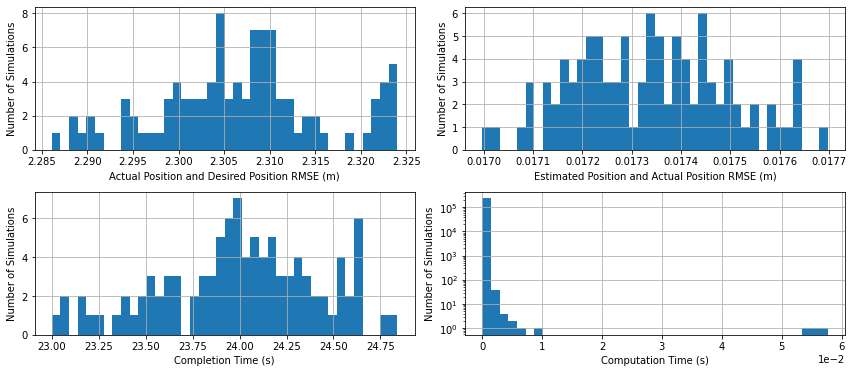

In [29]:
fig = plt.figure(figsize = (12,10), tight_layout= True)
f1 = fig.add_subplot(421)
f1.hist(actual_position_error, bins = 40)
f1.set_xlabel('Actual Position and Desired Position RMSE (m)')
f1.set_ylabel('Number of Simulations')
f1.grid()

f2 = fig.add_subplot(422)
f2.hist(estimated_position_error, bins = 40)
f2.set_xlabel('Estimated Position and Actual Position RMSE (m)')
f2.set_ylabel('Number of Simulations')
f2.grid()

f3 = fig.add_subplot(423)
f3.hist(completion_times, bins = 40)
f3.set_xlabel('Completion Time (s)')
f3.set_ylabel('Number of Simulations')
f3.grid()

f4 = fig.add_subplot(424)
f4.hist(run_times, bins = 40)
f4.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
f4.tick_params(labelsize=10)
f4.set_xlabel('Computation Time (s)')
f4.set_ylabel('Number of Simulations')
f4.set_yscale('log')
f4.grid()

# compute and print relevant statistics
print(f"\nThe number of simulations that have a run time less than or equal to 30 seconds: \n{count}")

print(f'\n70th %ile RMSE in regards to calculated vs actual position: \n{np.percentile(np.array(estimated_position_error), 70)}')
print(f'\nMaximum RMSE in regards to calculated vs actual position: \n{np.amax(np.array(estimated_position_error))}')


minimum = np.amin(np.array(completion_times))
print(f'\nMinimum completion time: \n{minimum}')

maximum = np.amax(np.array(completion_times))
print(f'\nMaximum completion time: \n{maximum}')

mean = np.mean(np.array(completion_times))
print(f'\nMean completion time: \n{mean}')

median = np.median(np.array(completion_times))
print(f'\nMedian completion time: \n{median}')

std = np.std(np.array(completion_times))
print(f'\nStandard deviation of completion times: \n{std}')

rt = np.array(run_times)
print(f'\nMinimum computation time: \n{np.amin(rt)}')
print(f'\nMaximum computation time: \n{np.amax(rt)}')
print(f'\nMean computation time: \n{np.mean(rt)}')
print(f'\nMedian computation time: \n{np.median(rt)}')


Save figure (optional)

In [24]:
# fig.savefig('agg_results.png', facecolor='white', transparent=False)

## Show how well the observer is working

Overlay the calculated (estimated) position with the actual position in all three axes

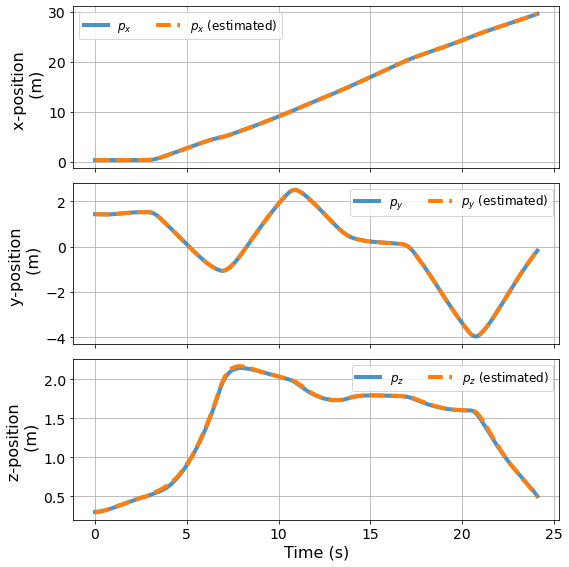

In [25]:
t = data['t']
p_x_data = data['p_x']
p_y_data = data['p_y']
p_z_data = data['p_z']
x1 = p_x_data - p_x_eq
x2 = p_y_data - p_y_eq
x3 = p_z_data - p_z_eq
xhat = data['xhat']

fig, (ax_x1, ax_x2, ax_x3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax_x1.plot(t, x1, label='$p_x$', linewidth=4, alpha=0.8)
ax_x1.plot(t, xhat[:, 0], '--', label=r'$p_x$ (estimated)', linewidth=4)

ax_x2.plot(t, x2, label='$p_y$', linewidth=4, alpha=0.8)
ax_x2.plot(t, xhat[:, 1], '--', label=r'$p_y$ (estimated)', linewidth=4)

ax_x3.plot(t, x3, label='$p_z$', linewidth=4, alpha=0.8)
ax_x3.plot(t, xhat[:, 2], '--', label=r'$p_z$ (estimated)', linewidth=4)

ax_x1.grid()
ax_x1.legend(fontsize=12, ncol=2)
ax_x1.tick_params(labelsize=14)
ax_x1.set_ylabel('x-position \n (m)', fontsize=16)

ax_x2.grid()
ax_x2.legend(fontsize=12, ncol=2)
ax_x2.tick_params(labelsize=14)
ax_x2.set_ylabel('y-position \n (m)', fontsize=16)

ax_x3.grid()
ax_x3.legend(fontsize=12, ncol=2)
ax_x3.tick_params(labelsize=14)
ax_x3.set_ylabel('z-position \n (m)', fontsize=16)
ax_x3.set_xlabel('Time (s)', fontsize=16)

fig.tight_layout()

Save figure (optional)

In [26]:
# fig.savefig('State_Estimate.png', facecolor='white', transparent=False)